# Transfer QAOA params between graphs


In [1]:
import qtensor
import networkx as nx
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats
%matplotlib inline
__plot_height = 2.719
matplotlib.rcParams['figure.figsize'] = (1.618*__plot_height, __plot_height)
set_matplotlib_formats('svg')

In [4]:
p = 7
gamma, beta = np.linspace(0, 1, p), np.linspace(1, 0, p)
gamma /= 2
beta /= 2

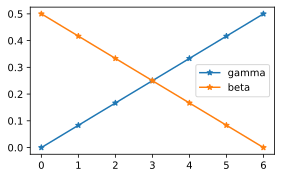

In [5]:
def plot_gamma_beta(gamma, beta):
    plt.plot(gamma,'*-',  label='gamma')
    plt.plot(beta, '*-', label='beta')
    plt.legend()
    
plot_gamma_beta(gamma, beta)

## Opitimize bethe lattice

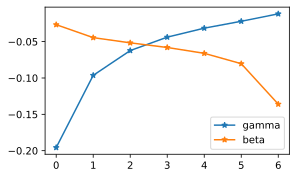

In [8]:
import json
parameters_nu3 = json.load(open('../parameters_nu3.json'))
def get_parameters_nu3(p):
    """
    Args:
        p(int)
    Returns:
        gamma, beta from 0 to 1
    """
    p_ =  parameters_nu3[str(p)]
    return np.array(p_['gamma'])/np.pi, np.array(p_['beta'])/np.pi

gamma, beta = get_parameters_nu3(p)
plot_gamma_beta(gamma, beta)

In [9]:
B = qtensor.toolbox.bethe_graph(p=p, degree=3)

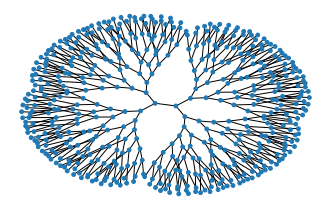

In [10]:
nx.draw_kamada_kawai(B, node_size=15)

In [11]:
from qtensor import parameter_optimization as popt
import torch

In [12]:
loss_history, params_history = popt.qaoa_maxcut_torch(B, gamma, beta,
                                                      ordering_algo='tamaki_120',
                                                      edge=(0, 1),
                                                      Opt=torch.optim.Adam,
                                                      opt_kwargs=dict(lr=0.006),
                                                      steps=480)

Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=1477, width=791
Time=1477, width=791
Time=1944, width=21
Time=1944, width=21
Time=2432, width=20
Time=2586, width=19
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=2758, width=17
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=12375, width=16
Time=1237

Treewidth 15


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


KeyboardInterrupt: 

Best solution: -0.6535008863865287
Best params: [array([0.03972292, 0.19843107, 0.18304115, 0.05000264, 0.02997042,
       0.2907956 , 0.30862865]), array([ 0.33075472,  0.46643184,  0.57177261,  0.17577581,  0.11428585,
        0.09358475, -0.04846567])]


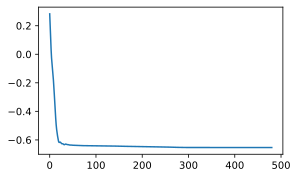

In [30]:
plt.plot(loss_history)
print('Best solution:', np.min(loss_history))
best_ix = np.argmin(loss_history)
best_params = params_history[best_ix]
print('Best params:', best_params)

In [31]:
estimate_cut = 1/2*(B.number_of_edges() - loss_history[best_ix]*B.number_of_edges())
approx_ratio = estimate_cut/B.number_of_edges()
print('Approx ratio:', approx_ratio)

Approx ratio: 0.8267504431932644


## Use multistart

In [17]:
def optimize_params(gamma, beta):
    loss_history, params_history = popt.qaoa_maxcut_torch(
        B, gamma, beta,
        ordering_algo='tamaki_120',
        edge=(0, 1),
        Opt=torch.optim.Adam,
        opt_kwargs=dict(lr=0.006),
        steps=180)
    best_ix = np.argmin(loss_history)
    best_params = params_history[best_ix]
    best_loss = loss_history[best_ix]
    return best_loss, best_params


In [15]:
from cartesian_explorer.parallels import JobLib

parallel = JobLib(processes=4)

In [21]:
N = 20
gamma, beta = np.random.randn(N, p), np.random.randn(N, p)
pargs = zip(gamma, beta)

In [ ]:
best_loss_params = parallel.starmap(optimize_params, pargs)

## Check the same parameters for random regular graph

Number of edges: 15


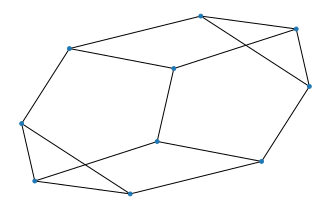

In [17]:
G = qtensor.toolbox.random_graph(nodes=10, degree=3, seed=10)
print('Number of edges:', G.number_of_edges())
nx.draw_kamada_kawai(G, node_size=15)

In [18]:
def maxcut_cost(G, gamma, beta):
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer)
    return sim.energy_expectation(G, gamma, beta)

In [19]:
maxcut_cost(G, *best_params)

array([12.33029447])

In [20]:
loss_history, param_history = popt.qaoa_maxcut_torch(G, gamma, beta, steps=20)

KeyboardInterrupt: 

Best energy: 20.805624


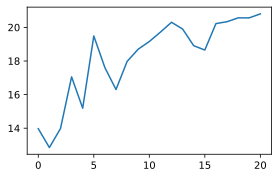

In [15]:
energies = - np.array(loss_history)
print('Best energy:', np.max(energies))
plt.plot(energies)

In [24]:
bound = qtensor.tools.maxcut.spectral_bound(G)
transfer_cost = maxcut_cost(G, *best_params)[0]
approx_ratio_bound = transfer_cost/(bound*G.number_of_edges())
print("Approx ratio bound =", approx_ratio_bound)
print("Approx ratio Bethe =", approx_ratio)


Approx ratio bound = 0.9039485906264829
Approx ratio Bethe = 0.8433088647040107


In [25]:
transfer_cost

12.330294472795362

In [31]:
transfer_cost/(bound*G.number_of_edges())

0.9039485906264829

## Compare for multiple graphs

In [33]:
from cartesian_explorer import Explorer
ex = Explorer()

In [34]:
@ex.provider
def graph(N, seed=10):
    return nx.random_regular_graph(d=3, n=N, seed=seed)

In [35]:
@ex.provider
def regular_approximation_bound(graph, p, bethe_params):
    gamma, beta = bethe_params
    bound = qtensor.tools.maxcut.spectral_bound(graph)
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, max_tw=25)
    try:
        transfer_cost = sim.energy_expectation(graph, gamma, beta)
    except Exception as e:
        print(e)
        return None
    approx_ratio_bound = transfer_cost/(bound*graph.number_of_edges())
    return approx_ratio_bound


In [36]:

@ex.provider
def bethe_approximation_cache(p):
    return qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val']

@ex.provider
def bethe_params_cache(p):
    gammabeta = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'] 
    gammabeta = np.array(gammabeta)
    gammabeta = gammabeta/np.pi
    gamma, beta = gammabeta[:p], gammabeta[p:]
    assert len(beta)==len(gamma), "Wrong parameters format, possibly unsolved p"
    return tuple(beta), tuple(gamma)
    

In [79]:
@ex.add_function(provides=('bethe_approximation', 'bethe_params'), requires=('p'))
def bethe_params(p, seed=10):
    B = qtensor.toolbox.bethe_graph(p=p, degree=3)
    gamma, beta = 1-np.cos(np.linspace(0,1,p)), 1-np.cos(np.linspace(0,1,p))
    loss_history, params_history = popt.qaoa_maxcut_torch(B, gamma, beta,
                                                          edge=(0, 1),
                                                          Opt=torch.optim.Adam,
                                                          opt_kwargs=dict(lr=0.006),
                                                          steps=200)
    best_ix = np.argmin(loss_history)
    best_loss = loss_history[best_ix]
    best_params = params_history[best_ix]
    estimate_cut = 1/2*(1 - best_loss)
    approx_ratio = estimate_cut
    return approx_ratio, (tuple(best_params[0]), tuple(best_params[1]))


Treewidth 26 is larger than max_tw=25.



Treewidth 26 is larger than max_tw=25.



Treewidth 27 is larger than max_tw=25.



Treewidth 29 is larger than max_tw=25.



Treewidth 31 is larger than max_tw=25.



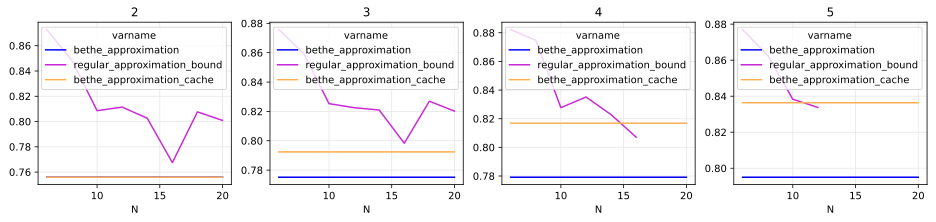

In [155]:
f = ex.plot2d(ex.get_variable,
          p=[2,3,4,5],
          varname=('bethe_approximation', 'regular_approximation_bound', 'bethe_approximation_cache'),
          N=range(6, 22, 2),
          seed=[10]
         )
plt.savefig('/tmp/plot_approx.png')

In [154]:
p = 3
gb = bethe_params_cache(p)
gamma, beta = gb
gamma, beta

((0.14625538825784332, 0.35087973860935995, 0.42500476233846124),
 (0.932857136289293, 0.19381151457591544, -0.12706819386164936))

In [153]:
maxcut_cost(G, -np.array(beta), -np.array(gamma))

array([7.0612915])

In [124]:
G.number_of_edges

15

In [37]:
bethe_approximation_cache(5)

0.8363793482380077

In [38]:
bethe_approximation_cache(6)

0.8498938819897202